In [1]:
import numpy as np 
import scipy.optimize as opt
import matplotlib.pyplot as plot
import os
import scipy.signal as sig

In [2]:
def load_data(folder_path, filename):
    # Load the ODMR data from the data_file 
    file_path = folder_path + filename + '.dat'

    ODMR_scan_full = np.loadtxt(file_path)
    mean_ODMR = np.mean(ODMR_scan_full, axis=0)
    
    return(ODMR_scan_full, mean_ODMR)

In [3]:
def load_params(folder_path, filename):
    # Load the parameter data for the frequency scan range. 
    params_file_path = folder_path + filename + 'Params'+'.dat'
    params = np.loadtxt(params_file_path, delimiter = '\t', usecols = 1)
    
    start = params[0]
    stop = params[1]
    step = params[2]*0.001
    no_of_steps = int((stop-start)/step) +1
   
    # Creates a variable containing the applied frequencies. 
    if start < stop:
        freq = np.linspace(start, stop, no_of_steps)
    else:
        freq = np.linspace(stop, start, no_of_steps)
        
    return(freq)

In [4]:
def normalise_to_background(data_set):
    
    fluor_baseline = np.mean(data_set[int(0.9*len(data_set)):len(data_set)])
    normalised_dataset = data_set/fluor_baseline
    return(normalised_dataset, fluor_baseline)

In [5]:
def double_gauss(x, a, x0, sigma, a2, x02, sigma2, c):
    
    gaussian_one = a*np.exp(-pow((x-x0),2)/pow((2*sigma),2))
    gaussian_two = a2*np.exp(-pow((x-x02),2)/pow((2*sigma2),2)) 
    
    total = gaussian_one + gaussian_two + c
    
    return(total)

In [6]:
def find_fluorescence_minima(mean_data):
    
    half = int(len(mean_data)/2)
    minima_1 = np.where(mean_data[0:half] == np.min(mean_data[0:half]))
    minima_2 = np.where(mean_data[half:len(mean_data)] == np.min(mean_data[half:len(mean_data)]))
    minima_2 = minima_2[0] + half
               
    return(minima_1, minima_2)

In [7]:
def find_contrast(mean_data, fluor_baseline, min1, min2):
    
    contrast_1 = float((mean_data[min1]-fluor_baseline)/fluor_baseline)
    contrast_2 = float((mean_data[min2]-fluor_baseline)/fluor_baseline)
               
    return(contrast_1, contrast_2)

In [23]:
def scatter_plot(ax, freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax.scatter(freq, mean_data, marker = 'x',color = 'r', label = "Experiment Data")
    ax.set_xlabel('Microwave frequency (GHz)')
    ax.set_ylabel('Normalised counts (A.U.)')
    return(fig, ax)

In [25]:
def plot_fitting_line(ax, freq, coeffs):
    
    x = np.linspace(np.min(freq), np.max(freq), len(freq))
    y = double_gauss(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3],coeffs[4], coeffs[5], coeffs[6])
    ax.plot(x, y, color = 'k', linewidth = '2', label = 'Gaussian line fit')
    ax.legend()
    return(x,y)

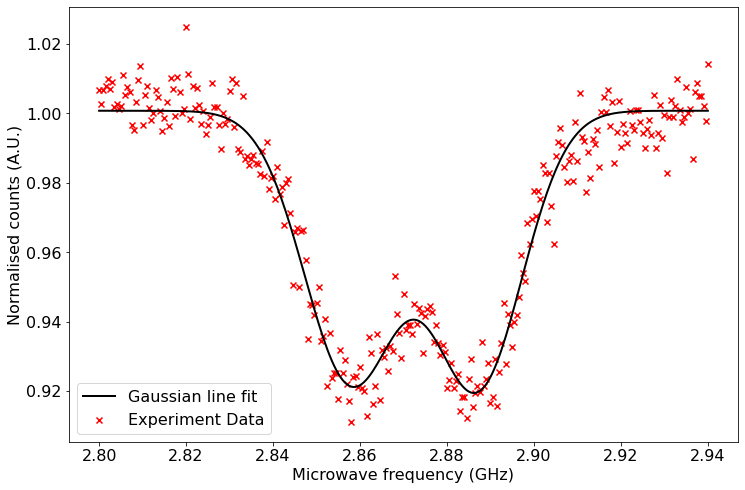

In [26]:
# Set the folder in which the data sits
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Thermometry\\20200124\\Scan1\\'
date = '20200124'
# Set the file path
file_name = ['20200124_Thermometry_Scan1_04']
fig, ax = plot.subplots()

for i in range(len(file_name)):
    
    # Get the data from the file. The full ODMR scan and then a single line scan.
    ODMR_full_scan, mean_ODMR = load_data(folder_path, file_name[i])
    # Get the frequency and normalised ODMR. 
    freq = load_params(folder_path, file_name[i])
    normalised_mean_ODMR, fluor_baseline = normalise_to_background(mean_ODMR)
    # Get the index for the minimum fluorescence value in the scan and the contrast. 
    min_index_1, min_index_2 = find_fluorescence_minima(normalised_mean_ODMR)
    contrast1, contrast2 = find_contrast(normalised_mean_ODMR, fluor_baseline, min_index_1, min_index_2)
    # set the intial parameters for the curve fitting. 
    init_params = [contrast1, float(freq[min_index_1]), 0.0005, contrast2,
               float(freq[min_index_2]), 0.0005, 1.0]
    # Plot the data as a scatter plot.
    scatter_plot(ax, freq, normalised_mean_ODMR)
    # Do a curve fit. 
    coeffs, confidence = opt.curve_fit(double_gauss, freq, normalised_mean_ODMR, init_params)
    opt_error = np.sqrt(np.diag(confidence))

    x, y = plot_fitting_line(ax, freq, coeffs)



In [27]:
fig.savefig('C:\\Users\\Ryan\\Desktop\\ODMR.pdf')

In [36]:
print(len(init_params))

7
